# Lift 提升图 Python实现

Lift提升图评估的是模型的区分能力相对于随机选择的提升度，一般过程是模型开发好之后，将模型的预测值按照评分从低到高进行排序(就是风险又高到到低，如果预测返回的是概率那就是一个降序排列)，平均分成n组，然后计算每组好坏的比例与总体样本好坏的比例进行对比。

In [148]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [149]:
def plot_lift(preds,labels,n,asc):
    '''
        preds:预测值，得分或者概率
        labels:实际值,值是0和1，其中1表示的是坏样本
        n:划分的区间个数
        asc:排列顺序，1表示的是升序，0表示的是降序；具体值是根据预测值的类型来定，如果越高表示风险越大则用降序，反之升序
    '''
    data=pd.DataFrame({'preds':preds,'labels':labels})
    
    #排序
    if asc==1:
        data.sort_values(by=['preds'],ascending=True,inplace=True)
    if asc==0:
        data.sort_values(by=['preds'],ascending=False,inplace=True)
    data.reset_index(drop=True, inplace=True)
    
    #分组
    data['group']=np.int16(data.index/(len(data.index)/n)+1)
    
    #统计
    data_bad=data.groupby(['group'])['labels'].agg('sum')
    
    data_cnt=data.groupby(['group'])['labels'].agg('count')
    
    dd=pd.DataFrame({'bad':data_bad,'cnt':data_cnt})
    
    dd['pre_bad_rat']=dd['bad']/dd['cnt']
    
    total_rat=data['labels'].sum()/data['labels'].count()
    
    dd['lift']=dd['pre_bad_rat']/total_rat
    plt.plot(dd.index,dd['lift'])
    plt.plot(dd.index,[total_rat]*len(dd.index))
    

In [150]:
# 使用scikit-learn自带的包来测试下
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [151]:
cancer = datasets.load_breast_cancer()
#print('breast_cancer数据集的长度为：',len(cancer))
#print('breast_cancer数据集的类型为：',type(cancer))
#print(cancer)
cancer_data = cancer['data']
cancer_target = cancer['target']
cancer_names = cancer['feature_names']
cancer_desc = cancer['DESCR']
#分为训练集与测试集
cancer_data_train,cancer_data_test = train_test_split(cancer_data,test_size=0.2,random_state=42)#训练集
cancer_target_train,cancer_target_test = train_test_split(cancer_target,test_size=0.2,random_state=42)#测试集
#使用sklearn转换器进行数据预处理//离差标准化
Scaler = MinMaxScaler().fit(cancer_data_train)#生成规则
cancer_trainScaler = Scaler.transform(cancer_data_train)
cancer_testScaler = Scaler.transform(cancer_data_test)#此处测试集使用了训练集规则，会有数据结果超过[0,1].

In [152]:
gbm0 = GradientBoostingClassifier(random_state=10)
gbm0.fit(cancer_trainScaler,cancer_target_train)
y_predprob = gbm0.predict_proba(cancer_testScaler)[:,1]

   labels     preds
0       1  0.999137
1       0  0.000369
2       0  0.001644
3       1  0.999563
4       1  0.999745
5       0  0.000464
6       0  0.000391
7       0  0.021241
8       1  0.298659
9       1  0.999083
   labels     preds  group
0       1  0.999755      1
1       1  0.999745      1
2       1  0.999735      1
3       1  0.999713      1
4       1  0.999663      1
5       1  0.999662      1
6       1  0.999659      1
7       1  0.999659      1
8       1  0.999633      1
9       1  0.999631      1
       bad  cnt  pre_bad_rat      lift
group                                 
1       15   15     1.000000  1.605634
2       14   14     1.000000  1.605634
3       14   14     1.000000  1.605634
4       14   14     1.000000  1.605634
5       12   15     0.800000  1.284507
6        2   14     0.142857  0.229376
7        0   14     0.000000  0.000000
8        0   14     0.000000  0.000000


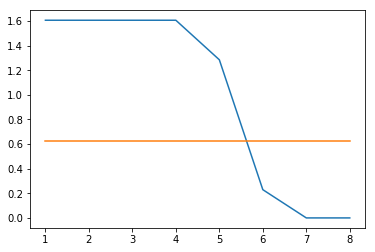

In [139]:
plot_lift(y_predprob,cancer_target_test,8,0)